In [18]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [19]:
root_path = "./"
file_name = "DP_Conjoint_Analysis_Project_responses"
dataset_path = os.path.join(root_path, "{}.csv".format(file_name))

In [20]:
# fields_dict = {
#     "F-1-1": "Gender",
#     "F-1-2": "Education",
#     "F-1-3": "Language Skills",
#     "F-1-4": "Country of Origin",
#     "F-1-5": "Job",
#     "F-1-6": "Job Experience",
#     "F-1-7": "Job Plans",
#     "F-1-8": "Reason for Application",
#     "F-1-9": "Prior Entry"
# }

In [21]:
NUM_OF_ATTR = 5
NUM_OF_ANSWER_OPTIONS = 3
NUM_OF_Q = 10

In [22]:
index_cols = ["ResponseId",
              "Q",
              "Choice"]

In [23]:
df = pd.read_csv(dataset_path)

### Pre-process

In [24]:
df = df.iloc[2:, :]
df = df[df["Status"] != "Survey Preview"]
df

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,F-10-3-3,F-10-4,F-10-1-4,F-10-2-4,F-10-3-4,F-10-5,F-10-1-5,F-10-2-5,F-10-3-5,Random ID
7,2022-07-07 09:12:41,2022-07-07 09:16:14,IP Address,35.129.41.222,100,212,True,2022-07-07 09:16:16,R_1f1OnOb3jjle14w,NaN,...,$$$$$,Retention period of shared data </br><h5>(How ...,Temporary,Temporary,Temporary,Sensitive disclosed data </br><h5>(What data i...,(Financial) Income,(Behavioral) Browsing History,(Financial) Income,4929
8,2022-07-07 09:19:25,2022-07-07 09:24:28,IP Address,47.196.84.74,100,303,True,2022-07-07 09:24:33,R_1o54HC4BnmPWCzb,NaN,...,Revenue generation,Retention period of shared data </br><h5>(How ...,Indefinitely,Indefinitely,Temporary,Privacy level: 1 (lowest) - 5 (highest) </br><...,3,4,4,3084
9,2022-07-07 09:27:36,2022-07-07 09:31:45,IP Address,24.11.144.82,100,248,True,2022-07-07 09:31:46,R_1OK7865efvihyCs,NaN,...,Temporary,How much would you sell your data for? <br><h5...,$$$$,$$$$$,$$$$$,Purpose of shared data </br><h5>(What is the p...,Revenue generation,Improvement of services,Improvement of services,3555
10,2022-07-07 10:07:47,2022-07-07 10:11:59,IP Address,38.34.109.97,100,251,True,2022-07-07 10:11:59,R_3GD3bMEAJv7BuFW,NaN,...,Revenue generation,Privacy level: 1 (lowest) - 5 (highest) </br><...,1,4,3,How much would you sell your data for? <br><h5...,$$$$$,$$$,$$$$$,6043
11,2022-07-07 10:26:10,2022-07-07 10:32:29,IP Address,67.249.183.203,100,378,True,2022-07-07 10:32:29,R_2PpXz6E049ZMkug,NaN,...,4,Sensitive disclosed data </br><h5>(What data i...,(Financial) Income,(Financial) Income,(Financial) Income,How much would you sell your data for? <br><h5...,$$$$$,$$$,$,8422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2022-07-22 12:45:52,2022-07-22 12:47:09,IP Address,208.219.29.198,100,77,True,2022-07-22 12:47:10,R_eP2Ks5sYPqYvhVD,NaN,...,(Financial) Income,Privacy level: 1 (lowest) - 5 (highest) </br><...,1,5,2,Purpose of shared data </br><h5>(What is the p...,Improvement of services,Revenue generation,Research,6794
143,2022-07-22 12:48:56,2022-07-22 12:50:09,IP Address,208.219.18.203,100,73,True,2022-07-22 12:50:10,R_2qt09jTTiIgeMKe,NaN,...,(Medical) Existence of Diabetes,Purpose of shared data </br><h5>(What is the p...,Research,Research,Improvement of services,How much would you sell your data for? <br><h5...,$$,$$$,$$$$$,3403
144,2022-07-22 12:48:20,2022-07-22 12:50:15,IP Address,208.219.18.212,100,115,True,2022-07-22 12:50:16,R_2yef5dwcoAltfQB,NaN,...,Temporary,How much would you sell your data for? <br><h5...,$$$$$,$$$,$$$$$,Sensitive disclosed data </br><h5>(What data i...,(Behavioral) Browsing History,(Behavioral) Browsing History,(Behavioral) Browsing History,9876
145,2022-07-22 12:59:47,2022-07-22 13:02:36,IP Address,204.217.154.201,100,169,True,2022-07-22 13:02:38,R_TjXQ4OrfbGpl9XH,NaN,...,(Behavioral) Browsing History,Retention period of shared data </br><h5>(How ...,Indefinitely,Indefinitely,Indefinitely,Purpose of shared data </br><h5>(What is the p...,Revenue generation,Improvement of services,Revenue generation,4708


In [25]:
print("Total respondents: {}".format(df.shape[0]))

 # Remove click-though speeders
click_through_speeders = df[df["Duration (in seconds)"].map(int) <= 30]
print("There are {} click through speeders!".format(click_through_speeders.shape[0]))

# Remove non-finished responses
non_finishers = df[df["Finished"] == "False"]
print("There are {} non-finished responses!".format(non_finishers.shape[0]))

df = df[(df["Duration (in seconds)"].map(int) > 30) & (df["Finished"] == "True")]
print("After removal of click-through respondents and non-finishers: {}".format(df.shape[0]))

Total respondents: 140
There are 1 click through speeders!
There are 1 non-finished responses!
After removal of click-through respondents and non-finishers: 139


In [26]:
data_dict = {}
for i, r in df.iterrows():
    response_id = r["ResponseId"]
    data_dict[response_id] = {}

    for q in range(1, NUM_OF_Q + 1):
        data_dict[response_id][q] = {}
        for o in range(1, NUM_OF_ANSWER_OPTIONS + 1):
            data_dict[response_id][q][o] = {}
            for a in range(1, NUM_OF_ATTR + 1):
                attribute = r["F-{}-{}".format(q, a)]
                option_attribute_level = r["F-{}-{}-{}".format(q, o, a)]
                data_dict[response_id][q][o][attribute] = option_attribute_level

                selection_choice = [int(s) for s in r["Q{}".format(q)].split() if s.isdigit()][0]
                is_selected = True if selection_choice == o else False
                data_dict[response_id][q][o]["selected"] = is_selected

In [27]:
clean_df = pd.DataFrame.from_dict({(i,j, k): data_dict[i][j][k]
                                   for i in data_dict.keys()
                                   for j in data_dict[i].keys()
                                   for k in data_dict[i][j].keys()},
                                  orient='index')
clean_df = clean_df.reset_index().rename(columns={"level_0": "ResponseId",
                                                  "level_1": "Q",
                                                  "level_2": "Choice"})

In [28]:
clean_df.columns = [c.split("<")[0].strip() for c in clean_df.columns]
clean_df["How much would you sell your data for?"] = clean_df["How much would you sell your data for?"].map(len)

In [29]:
clean_df.to_csv(os.path.join(root_path, "{}_processed.csv".format(file_name)), index=False)
clean_df

,ResponseId,Q,Choice,Privacy level: 1 (lowest) - 5 (highest),selected,Purpose of shared data,How much would you sell your data for?,Retention period of shared data,Sensitive disclosed data
0,R_1f1OnOb3jjle14w,1,1,2,False,Research,5,Temporary,(Medical) Existence of Diabetes
1,R_1f1OnOb3jjle14w,1,2,5,True,Improvement of services,4,Temporary,(Behavioral) Browsing History
2,R_1f1OnOb3jjle14w,1,3,5,False,Revenue generation,4,Indefinitely,(Financial) Income
3,R_1f1OnOb3jjle14w,2,1,1,True,Revenue generation,5,Temporary,(Financial) Income
4,R_1f1OnOb3jjle14w,2,2,2,False,Revenue generation,4,Indefinitely,(Financial) Income
...,...,...,...,...,...,...,...,...,...
4165,R_125AJqhKkeaDA2c,9,2,3,True,Revenue generation,1,Temporary,(Behavioral) Browsing History
4166,R_125AJqhKkeaDA2c,9,3,2,False,Revenue generation,1,Temporary,(Behavioral) Browsing History
4167,R_125AJqhKkeaDA2c,10,1,1,False,Revenue generation,5,Indefinitely,(Medical) Existence of Diabetes
4168,R_125AJqhKkeaDA2c,10,2,3,True,Improvement of services,1,Indefinitely,(Financial) Income


In [30]:
target_var = 'selected'

In [31]:
# remove unnecessary columns
clean_df = clean_df.drop(columns=index_cols, axis=1)

# remove empty data
clean_df = clean_df[~clean_df[target_var].isnull()]

In [32]:
y = clean_df[target_var]
x = clean_df[[x for x in clean_df.columns if x != target_var]]

In [33]:
xdum = pd.get_dummies(x, columns=[c for c in x.columns if c != target_var])
xdum.head()

,Privacy level: 1 (lowest) - 5 (highest)_1,Privacy level: 1 (lowest) - 5 (highest)_2,Privacy level: 1 (lowest) - 5 (highest)_3,Privacy level: 1 (lowest) - 5 (highest)_4,Privacy level: 1 (lowest) - 5 (highest)_5,Purpose of shared data_Improvement of services,Purpose of shared data_Research,Purpose of shared data_Revenue generation,How much would you sell your data for?_1,How much would you sell your data for?_2,How much would you sell your data for?_3,How much would you sell your data for?_4,How much would you sell your data for?_5,Retention period of shared data_Indefinitely,Retention period of shared data_Temporary,Sensitive disclosed data_(Behavioral) Browsing History,Sensitive disclosed data_(Financial) Income,Sensitive disclosed data_(Medical) Existence of Diabetes
0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1
1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0
2,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
3,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0


### Run OLS

In [36]:
xdum = sm.add_constant(xdum)
# res = sm.OLS(y, xdum, family=sm.families.Binomial()).fit()
res = sm.OLS(y, xdum).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               selected   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     13.18
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           4.32e-29
Time:                        11:24:37   Log-Likelihood:                -2696.7
No. Observations:                4170   AIC:                             5421.
Df Residuals:                    4156   BIC:                             5510.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                    -4.706e+11   1.22e+12     -0.384      0.701   -2.87e+12    1.93e+12
Privacy level: 1 (lowest) - 5 (highest)_1                -5.171e+11   9.67e+11     -0.535      0.593   -2.41e+12    1.38e+12
Privacy level: 1 (lowest) - 5 (highest)_2                -5.171e+11   9.67e+11     -0.535      0.593   -2.41e+12    1.38e+12
Privacy level: 1 (lowest) - 5 (highest)_3                -5.171e+11   9.67e+11     -0.535      0.593   -2.41e+12    1.38e+12
Privacy level: 1 (lowest) - 5 (highest)_4                -5.171e+11   9.67e+11     -0.535      0.593   -2.41e+12    1.38e+12
Privacy level: 1 (lowest) - 5 (highest)_5                -5.171e+11   9.67e+11     -0.535      0.593   -2.41e+12    1.38e+12
Purpose of shared data_Improvement of services            5.942e+11   8.91e+11      0.667      0.505   -1.15e+12    2.34e+12
Purpose of shared data_Research                           5.942e+11   8.91e+11      0.667      0.505   -1.15e+12    2.34e+12
Purpose of shared data_Revenue generation                 5.942e+11   8.91e+11      0.667      0.505   -1.15e+12    2.34e+12
How much would you sell your data for?_1                  5.634e+10   9.22e+10      0.611      0.541   -1.24e+11    2.37e+11
How much would you sell your data for?_2                  5.634e+10   9.22e+10      0.611      0.541   -1.24e+11    2.37e+11
How much would you sell your data for?_3                  5.634e+10   9.22e+10      0.611      0.541   -1.24e+11    2.37e+11
How much would you sell your data for?_4                  5.634e+10   9.22e+10      0.611      0.541   -1.24e+11    2.37e+11
How much would you sell your data for?_5                  5.634e+10   9.22e+10      0.611      0.541   -1.24e+11    2.37e+11
Retention period of shared data_Indefinitely              6.095e+11   9.29e+11      0.656      0.512   -1.21e+12    2.43e+12
Retention period of shared data_Temporary                 6.095e+11   9.29e+11      0.656      0.512   -1.21e+12    2.43e+12
Sensitive disclosed data_(Behavioral) Browsing History   -2.724e+11   6.33e+11     -0.430      0.667   -1.51e+12    9.68e+11
Sensitive disclosed data_(Financial) Income              -2.724e+11   6.33e+11     -0.430      0.667   -1.51e+12    9.68e+11
Sensitive disclosed data_(Medical) Existence of Diabetes -2.724e+11   6.33e+11     -0.430      0.667   -1.51e+12    9.68e+11
==============================================================================
Omnibus:                    53477.203   Durbin-Watson:                   2.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              634.949
Skew:                           0.663   Prob(JB):                    1.33e-138
Kurtosis:        

### Analyze

In [37]:
df_res = pd.DataFrame({
    'param_name': res.params.keys()
    , 'param_w': res.params.values
    , 'pval': res.pvalues
})
# adding field for absolute of parameters
df_res['abs_param_w'] = np.abs(df_res['param_w'])
# marking field is significant under 95% confidence interval
df_res['is_sig_95'] = (df_res['pval'] < 0.05)
# constructing color naming for each param
df_res['c'] = ['blue' if x else 'red' for x in df_res['is_sig_95']]

# make it sorted by abs of parameter value
df_res = df_res.sort_values(by='abs_param_w', ascending=True)
# make it sorted by attribute name
df_res = df_res.sort_values(by='param_name', ascending=True)

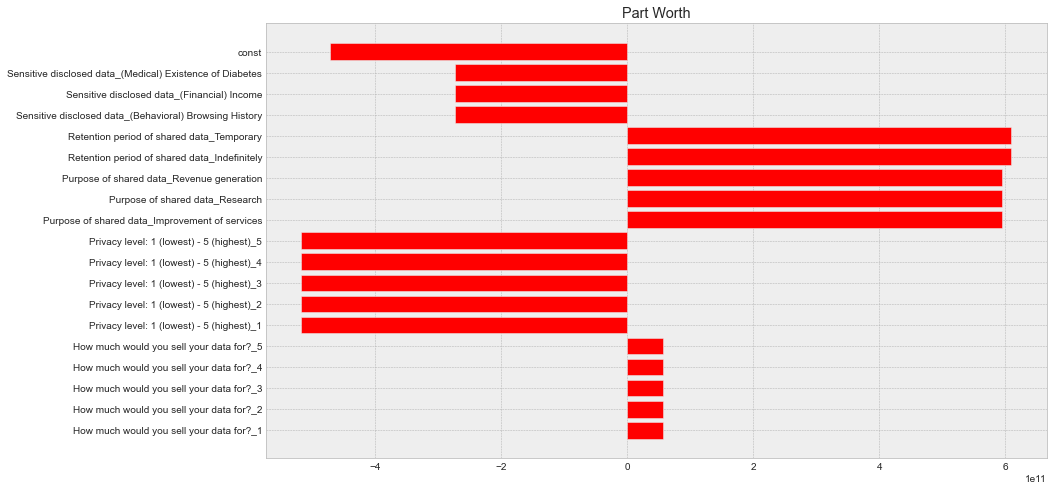

In [38]:
f, ax = plt.subplots(figsize=(14, 8))
plt.title('Part Worth')
pwu = df_res['param_w']
xbar = np.arange(len(pwu))
plt.barh(xbar, pwu, color=df_res['c'])
plt.yticks(xbar, labels=df_res['param_name'])
plt.show()

In [39]:
pwu.reset_index()

,index,param_w
0,How much would you sell your data for?_1,5.634455e+10
1,How much would you sell your data for?_2,5.634455e+10
2,How much would you sell your data for?_3,5.634455e+10
3,How much would you sell your data for?_4,5.634455e+10
4,How much would you sell your data for?_5,5.634455e+10
5,Privacy level: 1 (lowest) - 5 (highest)_1,-5.170580e+11
6,Privacy level: 1 (lowest) - 5 (highest)_2,-5.170580e+11
7,Privacy level: 1 (lowest) - 5 (highest)_3,-5.170580e+11
8,Privacy level: 1 (lowest) - 5 (highest)_4,-5.170580e+11
9,Privacy level: 1 (lowest) - 5 (highest)_5,-5.170580e+11


In [40]:
# need to assemble per attribute for every level of that attribute in dicionary
range_per_feature = dict()
for key, coeff in res.params.items():
    sk =  key.split('_')
    feature = sk[0]
    if len(sk) == 1:
        feature = key
    if feature not in range_per_feature:
        range_per_feature[feature] = list()
        
    range_per_feature[feature].append(coeff)

In [41]:
means_dict = {}
std_dict = {}
for k, vs in range_per_feature.items():
    means_dict[k] = np.mean(vs)
    std_dict[k] = np.std(vs)

new_pwu = {}
for k, v in dict(pwu).items():
    attribute =  k.split('_')[0]
    mean = means_dict[attribute]
    std = std_dict[attribute]
    new_v = (v - mean) / std
    new_pwu[k] = new_v

C:\Users\user\AppData\Local\Temp\ipykernel_17952\2672308717.py:12: RuntimeWarning: invalid value encountered in double_scalars
  new_v = (v - mean) / std


In [42]:
new_pwu_df = pd.DataFrame(list(new_pwu.values()), index=list(new_pwu.keys()))
new_pwu_df

,0
How much would you sell your data for?_1,-1.379053
How much would you sell your data for?_2,-0.859121
How much would you sell your data for?_3,0.153127
How much would you sell your data for?_4,0.756017
How much would you sell your data for?_5,1.328576
Privacy level: 1 (lowest) - 5 (highest)_1,-1.306576
Privacy level: 1 (lowest) - 5 (highest)_2,-0.997460
Privacy level: 1 (lowest) - 5 (highest)_3,0.208202
Privacy level: 1 (lowest) - 5 (highest)_4,0.884860
Privacy level: 1 (lowest) - 5 (highest)_5,1.213098


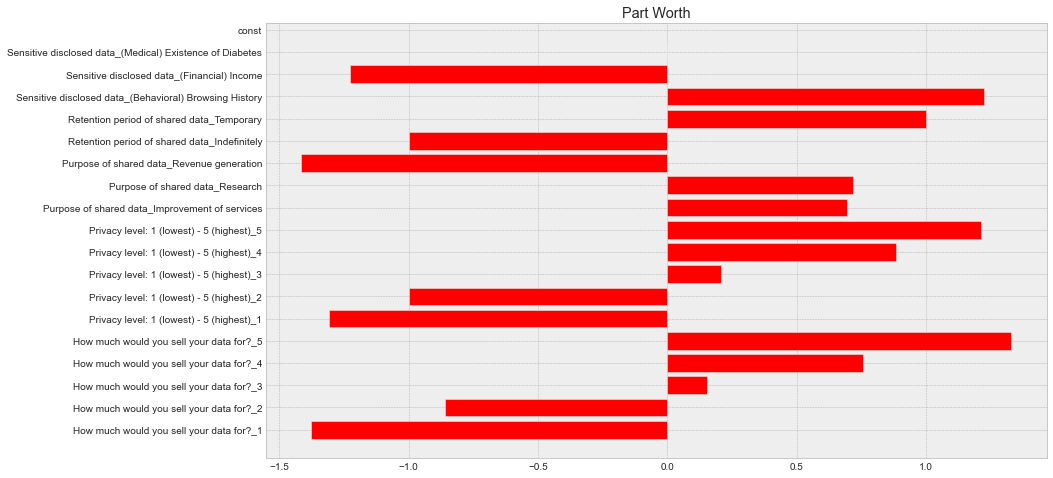

In [43]:
f, ax = plt.subplots(figsize=(14, 8))
plt.title('Part Worth')
# pwu = df_res['param_w']
xbar = np.arange(len(new_pwu))
plt.barh(xbar, new_pwu_df[0], color=df_res['c'])
plt.yticks(xbar, labels=df_res['param_name'])
plt.show()

In [44]:
# importance per feature is range of coef in a feature
# while range is simply max(x) - min(x)
importance_per_feature = {
    # k: max(v) - min(v) for k, v in range_per_feature.items()
    k: max(v) - min(v) for k, v in list(range_per_feature.items())[1:]
}

# compute relative importance per feature
# or normalized feature importance by dividing 
# sum of importance for all features
total_feature_importance = sum(importance_per_feature.values())
relative_importance_per_feature = {
    k: 100 * round(v/total_feature_importance, 3) for k, v in importance_per_feature.items()
}


In [45]:
relative_importance_per_feature

{'Privacy level: 1 (lowest) - 5 (highest)': 31.900000000000002,
 'Purpose of shared data': 14.6,
 'How much would you sell your data for?': 40.300000000000004,
 'Retention period of shared data': 8.9,
 'Sensitive disclosed data': 4.3}

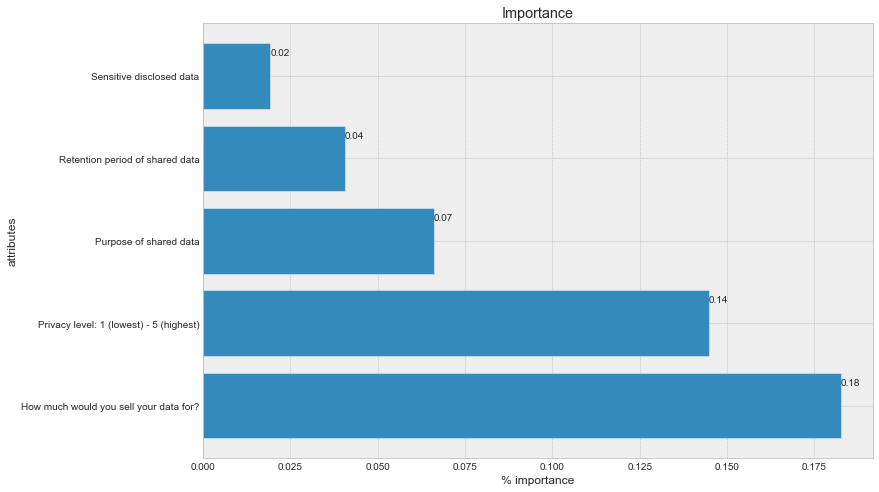

In [46]:
alt_data = pd.DataFrame(
    list(importance_per_feature.items()), 
    columns=['attr', 'importance']
).sort_values(by='importance', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Importance')
plt.barh(xbar, alt_data['importance'])
for i, v in enumerate(alt_data['importance']):
    ax.text(v , i + .25, '{:.2f}'.format(v))
plt.ylabel('attributes')
plt.xlabel('% importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()

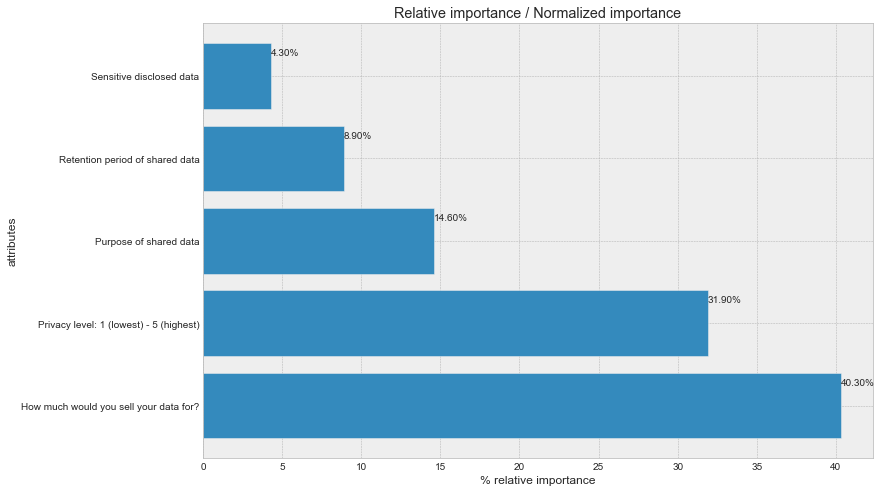

In [47]:
alt_data = pd.DataFrame(
    list(relative_importance_per_feature.items()), 
    columns=['attr', 'relative_importance (pct)']
).sort_values(by='relative_importance (pct)', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Relative importance / Normalized importance')
plt.barh(xbar, alt_data['relative_importance (pct)'])
for i, v in enumerate(alt_data['relative_importance (pct)']):
    ax.text(v , i + .25, '{:.2f}%'.format(v))
plt.ylabel('attributes')
plt.xlabel('% relative importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()